In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-stock-price/NETFLIX_weekly.csv
/kaggle/input/netflix-stock-price/META_weekly.csv
/kaggle/input/netflix-stock-price/APPLE_monthly.csv
/kaggle/input/netflix-stock-price/GOOGLE_daily.csv
/kaggle/input/netflix-stock-price/NETFLIX_monthly.csv
/kaggle/input/netflix-stock-price/AMAZON_daily.csv
/kaggle/input/netflix-stock-price/APPLE_weekly.csv
/kaggle/input/netflix-stock-price/META_monthly.csv
/kaggle/input/netflix-stock-price/AMAZON_monthly.csv
/kaggle/input/netflix-stock-price/GOOGLE_monthly.csv
/kaggle/input/netflix-stock-price/GOOGLE_weekly.csv
/kaggle/input/netflix-stock-price/APPLE_daily.csv
/kaggle/input/netflix-stock-price/META_daily.csv
/kaggle/input/netflix-stock-price/AMAZON_weekly.csv
/kaggle/input/netflix-stock-price/NETFLIX_daily.csv


# GOAL: Forecast weekly stockprices of the various MAANG datasets in order to try and predict future stock prices

### Initial Data Inspection

In [13]:
amazon_df = pd.read_csv("/kaggle/input/netflix-stock-price/AMAZON_weekly.csv")

# Quick look at the data
print(amazon_df.tail(10))
print(amazon_df.shape)

            Date        Open        High         Low       Close   Adj Close  \
1439  2024-12-09  227.210007  231.199997  224.199997  227.460007  227.460007   
1440  2024-12-16  230.229996  233.000000  218.729996  224.919998  224.919998   
1441  2024-12-23  225.009995  229.139999  220.899994  223.750000  223.750000   
1442  2024-12-30  220.059998  225.360001  218.190002  224.190002  224.190002   
1443  2025-01-06  226.779999  228.839996  216.500000  218.940002  218.940002   
1444  2025-01-13  218.059998  226.509995  216.199997  225.940002  225.940002   
1445  2025-01-20  228.899994  236.399994  226.940002  234.850006  234.850006   
1446  2025-01-27  226.210007  241.770004  225.860001  237.679993  237.679993   
1447  2025-02-03  234.059998  242.520004  228.059998  229.149994  229.149994   
1448  2025-02-07  232.740005  234.809906  228.070007  229.149994  229.149994   

         Volume  
1439  170377300  
1440  244979500  
1441   86591300  
1442  114613100  
1443  121778800  
1444  15039

In [14]:
# Initial types, # of null entries
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1449 non-null   object 
 1   Open       1449 non-null   float64
 2   High       1449 non-null   float64
 3   Low        1449 non-null   float64
 4   Close      1449 non-null   float64
 5   Adj Close  1449 non-null   float64
 6   Volume     1449 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 79.4+ KB


In [15]:
# Need to convert date from object to datetime for ease of use later
from datetime import datetime
amazon_df["Date"] = pd.to_datetime(amazon_df['Date'])
amazon_df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,1449,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1.449000e+03
mean,2011-03-27 23:57:01.118012416,40.459060,41.805969,39.255854,40.622921,40.622921,6.558927e+08
min,1997-05-12 00:00:00,0.075521,0.077083,0.065625,0.074479,0.074479,7.753928e+07
25%,2004-04-19 00:00:00,2.095500,2.206500,1.989000,2.111000,2.111000,3.183035e+08
50%,2011-03-28 00:00:00,9.007500,9.250000,8.738500,9.000000,9.000000,5.092040e+08
75%,2018-03-05 00:00:00,71.251503,75.174500,68.260002,72.366997,72.366997,7.697480e+08
max,2025-02-07 00:00:00,234.059998,242.520004,228.070007,237.679993,237.679993,5.383008e+09
std,NaN,57.830330,59.682489,56.192874,58.046093,58.046093,5.636185e+08


In [17]:
# Quick visualization of initial relevant trends
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
Fig = px.line(amazon_df, x=amazon_df["Date"], y=amazon_df['Close'], title='Amazon Closing Price Over Time')
Fig.show()
Fig = px.line(amazon_df, x=amazon_df["Date"], y=amazon_df['Volume'], title='Amazon Volume Over Time')
Fig.show()

### It appears that as price increased, volume decreased for the most part which is expected

In [18]:
amazon_df.corr()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,1.000000,0.819592,0.819674,0.819289,0.819846,0.819846,-0.529848
Open,0.819592,1.000000,0.999526,0.999411,0.998808,0.998808,-0.366875
High,0.819674,0.999526,1.000000,0.999275,0.999448,0.999448,-0.364452
Low,0.819289,0.999411,0.999275,1.000000,0.999420,0.999420,-0.369417
Close,0.819846,0.998808,0.999448,0.999420,1.000000,1.000000,-0.367085
Adj Close,0.819846,0.998808,0.999448,0.999420,1.000000,1.000000,-0.367085
Volume,-0.529848,-0.366875,-0.364452,-0.369417,-0.367085,-0.367085,1.000000


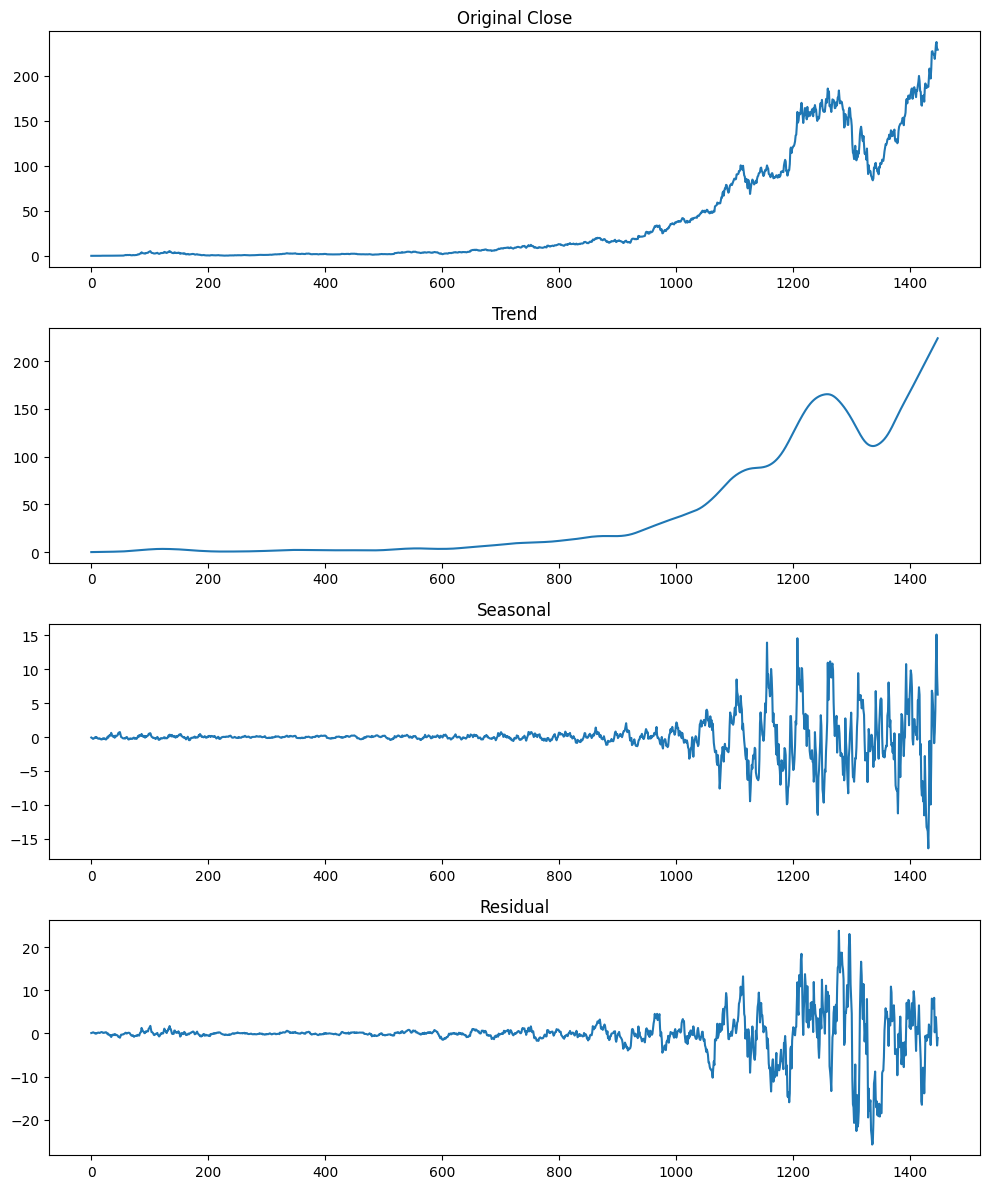

In [19]:
from statsmodels.tsa.seasonal import STL

close = amazon_df["Close"]
stl = STL(close, period=52)
stl_res = stl.fit()
trend = stl_res.trend
seasonal = stl_res.seasonal
residual = stl_res.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,12))
ax1.plot(close)
ax1.set_title("Original Close")

ax2.plot(trend)
ax2.set_title("Trend")

ax3.plot(seasonal)
ax3.set_title("Seasonal")

ax4.plot(residual)
ax4.set_title("Residual")

plt.tight_layout()
plt.show()

In [20]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
# load and preprocess data
df = pd.read_csv("/kaggle/input/netflix-stock-price/AMAZON_weekly.csv")
df['Date'] = pd.to_datetime(df['Date'])

# constant 'item_id' column (required for TS dataframe)
df['item_id'] = 'amazon'  # unique identifier for the stock

# rolling Avg features
df["rolling_close"] = df["Close"].rolling(window=4).mean()
df["rolling_open"] = df["Open"].rolling(window=4).mean()
df["rolling_volume"] = df["Volume"].rolling(window=4).mean()

# lags
lags = [1, 2, 3]
df[[f'close_lag_{i}' for i in lags]] = df['Close'].shift(lags)

In [21]:
# prepare data splits
train_size = 1350  # first 1350 rows for training
forecast_size = 99 # last 99 rows for forecasting

train_data = df.iloc[:train_size]
test_data = df.iloc[-forecast_size:]

# convert the dataframe to time series dataframe
ts_train_data = TimeSeriesDataFrame.from_data_frame(
    train_data,
    id_column="item_id",
    timestamp_column="Date",
)

ts_test_data = TimeSeriesDataFrame.from_data_frame(
    test_data,
    id_column="item_id",  # col identifying the time series
    timestamp_column="Date",  # col w/the timestamps
)

In [22]:
# define and train predictor
predictor = TimeSeriesPredictor(
    target="Close",
    prediction_length=53,
    eval_metric="MAPE",
    path="ag_stock_forecast",
)
predictor.fit(ts_train_data, time_limit=300)

# forecast
forecast = predictor.predict(ts_test_data)

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to '/kaggle/working/ag_stock_forecast'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
GPU Count:          0
Memory Avail:       29.92 GB / 31.35 GB (95.4%)
Disk Space Avail:   19.31 GB / 19.52 GB (99.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 53,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'Close',
 'time_limit': 300,
 'verbosity': 2}

Inferred time series frequency: 'W-MON'
Provided train_data has 1350 rows, 1 time series. Median time 

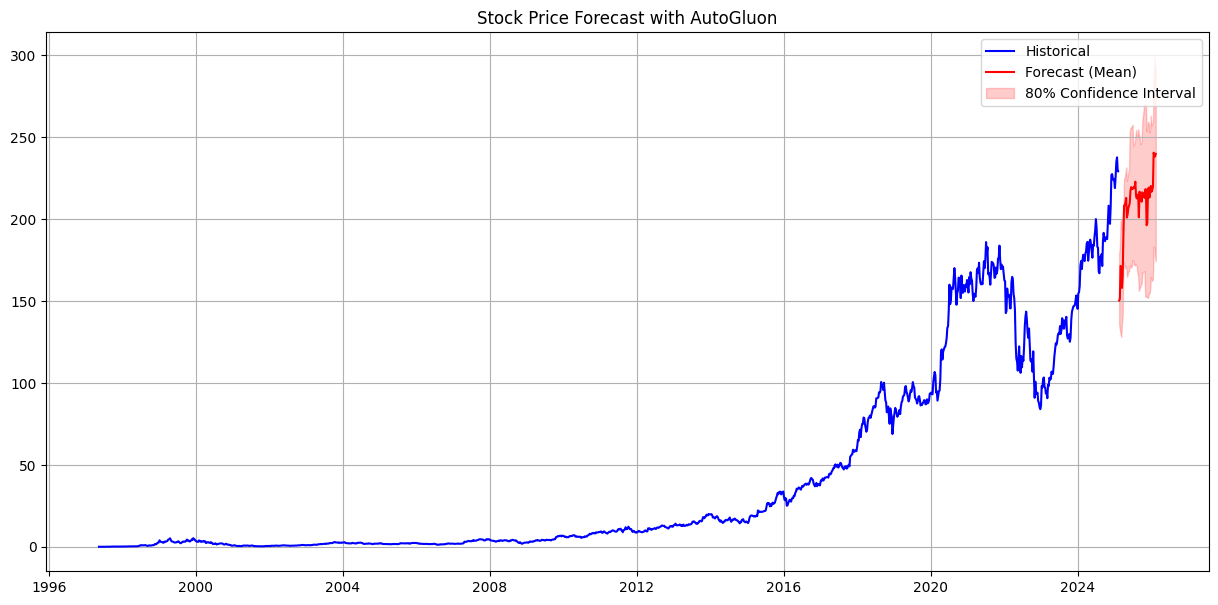

In [23]:
# visualization
plt.figure(figsize=(15, 7))

# historical data
df.set_index('Date', inplace=True)
plt.plot(df.index, df['Close'], label='Historical', color='blue')

# mean forecast
plt.plot(forecast.index.get_level_values(1), forecast['mean'], 
         label='Forecast (Mean)', linestyle='-', color='red')

# confidence intervals
plt.fill_between(forecast.index.get_level_values(1),
                forecast['0.1'],  # 10th percentile
                forecast['0.9'],  # 90th percentile
                alpha=0.2, color='red',
                label='80% Confidence Interval')

plt.title('Stock Price Forecast with AutoGluon')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Print forecast metrics
print("\nForecast Evaluation:")
print(predictor.evaluate(ts_test_data))

# Print forecast values
print("\nForecast Values (Mean):")
print(forecast['mean'].mean())

# Print confidence intervals
print("\n80% Confidence Interval:")
print("Lower bound Mean (10th percentile):", forecast['0.1'].mean())
print("Upper bound Mean (90th percentile):", forecast['0.9'].mean())

data with frequency 'None' has been resampled to frequency 'W-MON'.



Forecast Evaluation:


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'MAPE': -0.32267111108054064}

Forecast Values (Mean):
208.97103355955954

80% Confidence Interval:
Lower bound Mean (10th percentile): 162.6166375663404
Upper bound Mean (90th percentile): 245.95242786119096


In [25]:
from prophet import Prophet

# load the data again
df = pd.read_csv("/kaggle/input/netflix-stock-price/AMAZON_daily.csv")

# convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# rename columns to match Prophet's expected format
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})

# drop unnecessary columns
df = df[['ds', 'y']]

In [26]:
# check for missing values
print(df.isnull().sum())

print(df.head())

ds    0
y     0
dtype: int64
          ds         y
0 1997-05-15  0.097917
1 1997-05-16  0.086458
2 1997-05-19  0.085417
3 1997-05-20  0.081771
4 1997-05-21  0.071354


In [27]:
# initialize model
model = Prophet()

# fit model on historical data
model.fit(df)

# dataframe to hold future dates
future = model.make_future_dataframe(periods=30)

# predict
forecast = model.predict(future)

# display forecasted values
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30))

19:55:34 - cmdstanpy - INFO - Chain [1] start processing
19:55:36 - cmdstanpy - INFO - Chain [1] done processing


             ds        yhat  yhat_lower  yhat_upper
6978 2025-02-08  176.572860  158.684907  194.616463
6979 2025-02-09  176.500552  157.670958  195.796926
6980 2025-02-10  177.110233  158.846207  195.295407
6981 2025-02-11  176.945638  158.224107  195.890846
6982 2025-02-12  176.771525  158.711339  197.164153
6983 2025-02-13  176.683271  158.134104  195.358708
6984 2025-02-14  176.474562  159.098517  195.113592
6985 2025-02-15  175.876113  157.901637  196.053254
6986 2025-02-16  175.755679  156.291227  194.017719
6987 2025-02-17  176.328919  157.844742  194.374619
6988 2025-02-18  176.140058  157.346449  194.388858
6989 2025-02-19  175.954112  158.454535  195.336014
6990 2025-02-20  175.866476  157.835146  195.809623
6991 2025-02-21  175.670626  157.611922  193.186860
6992 2025-02-22  175.096842  156.081301  193.978102
6993 2025-02-23  175.012230  156.650875  194.441177
6994 2025-02-24  175.631614  157.396899  192.232362
6995 2025-02-25  175.498208  157.853005  193.101992
6996 2025-02

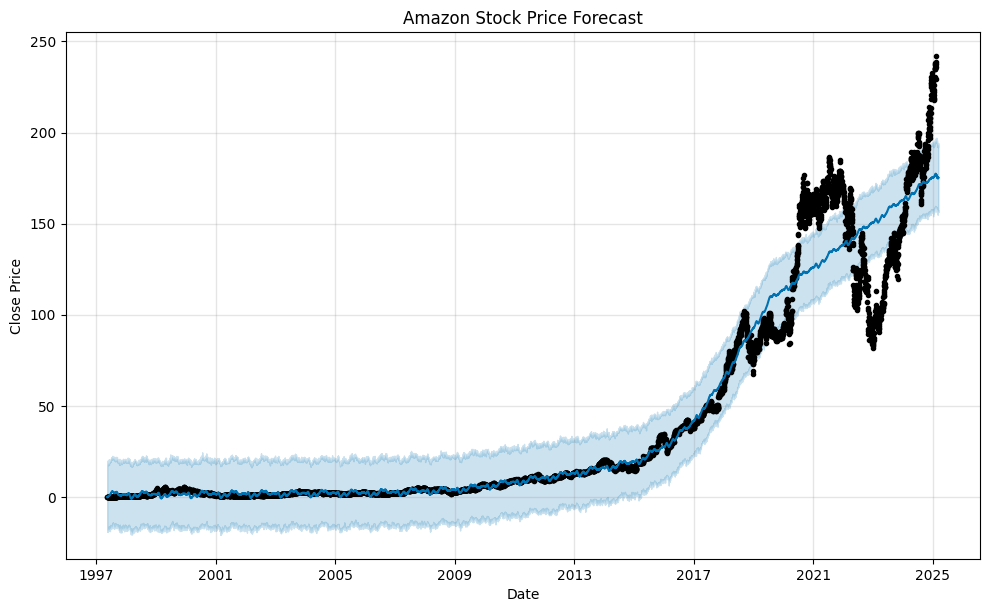

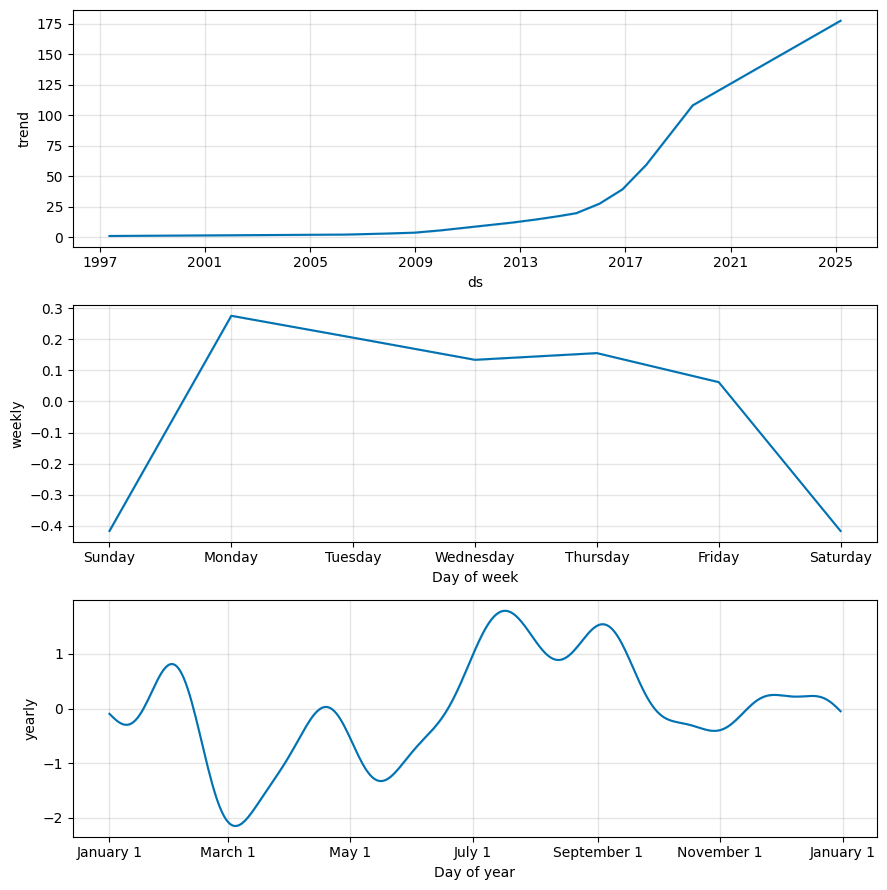

In [28]:
# plot forecast
model.plot(forecast)
plt.title('Amazon Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# plot forecast components
model.plot_components(forecast)
plt.show()